In [1]:
from pprint import pprint

In [6]:
pwd

'c:\\Users\\annka\\OneDrive\\Desktop\\NUS\\Year 4 Sem 2\\DSA4263\\dsa4263-pietonium\\dsa4263-pietonium'

# Preprocessing
Process the text on the Text column, and create a new column processed_text to store the processed text

In [2]:
from deployment.preprocess_fn import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
# read in raw data
df_path = 'data/raw/reviews.csv'
df = pd.read_csv(df_path, parse_dates = ['Time'])
df.head()

,Sentiment,Time,Text
0,positive,2021-06-18,This is a very healthy dog food. Good for thei...
1,positive,2021-07-07,I've been very pleased with the Natural Balanc...
2,positive,2021-06-18,"Before I was educated about feline nutrition, ..."
3,positive,2021-07-07,"My holistic vet recommended this, along with a..."
4,positive,2021-01-07,I bought this coffee because its much cheaper ...


In [9]:
%%time
# preprocess the text
df = preprocess(df, label_col_name = 'Sentiment')

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\annka/nltk_data'
    - 'c:\\Users\\annka\\anaconda3\\nltk_data'
    - 'c:\\Users\\annka\\anaconda3\\share\\nltk_data'
    - 'c:\\Users\\annka\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\annka\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


In [6]:
df.head()

,Sentiment,Time,Text,processed_text
0,1,2021-06-18,This is a very healthy dog food. Good for thei...,healthy dog food good digestion also good smal...
1,1,2021-07-07,I've been very pleased with the Natural Balanc...,pleased natural balance dog food dog issue dog...
2,1,2021-06-18,"Before I was educated about feline nutrition, ...",educate feline nutrition allow cat become addi...
3,1,2021-07-07,"My holistic vet recommended this, along with a...",holistic vet recommend along brand try cat pre...
4,1,2021-01-07,I bought this coffee because its much cheaper ...,buy coffee much cheaper ganocafe organic reish...


In [7]:
# show the preprocessed text
for i in range(3):
    print(f'Row {i}')
    print('-----')
    print(df.iloc[i]['Text'])
    print()
    print(df.iloc[i]['processed_text'])
    print()

Row 0
-----
This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.

healthy dog food good digestion also good small puppy dog eats require amount every feeding

Row 1
-----
I've been very pleased with the Natural Balance dog food. Our dogs have had issues with other dog foods in the past and I had someone recommend Natural Balance grain free since it is possible they were allergic to grains. Since switching I haven't had any issues. It is also helpful that have have different kibble size for larger/smaller sized dogs.

pleased natural balance dog food dog issue dog food past someone recommend natural balance grain free since possible allergic grain since switch issue also helpful different kibble size larger smaller sized dog

Row 2
-----
Before I was educated about feline nutrition, I allowed my cats to become addicted to dry cat food. I always offered both canned and dry, but wish I would have fed them

## EDA

# Sentiment Analysis

In [8]:
# train test split
x_train, x_test, y_train, y_test = split_train_test(df['processed_text'], df['Sentiment'])

In [9]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4355,) (4355,)
(1089,) (1089,)


## Training - XGBoost

In [10]:
from sentiment_analysis.ML.xgboost_model import xgb_instantiate_tfidf_vectorizer, xgb_instantiate_xgb_model, xgb_get_classification_report, xgb_print_classifcation_rerport, xgb_get_confusion_matrix

In [11]:
# initialise tfidf vectorizer and fit train data into it
xgboost_vectorizer = xgb_instantiate_tfidf_vectorizer(x_train)
train_vectors = xgboost_vectorizer.transform(x_train)
test_vectors = xgboost_vectorizer.transform(x_test)

In [12]:
print(train_vectors.shape)
print(test_vectors.shape)

(4355, 9246)
(1089, 9246)


In [13]:
# initialise xgb and fit training features and labels into it
xgb_model = xgb_instantiate_xgb_model(train_vectors, y_train)

## Training - SVM

In [ ]:
from sentiment_analysis.ML.uy_svm1 import svm_instantiate_tfidf_vectorizer, svm_instantiate_svm_model, svm_get_classification_report, svm_print_classifcation_rerport, svm_get_confusion_matrix

In [ ]:
# initialise tfidf vectorizer and fit train data into it
svm_vectorizer = svm_instantiate_tfidf_vectorizer(x_train)
train_vectors = svm_vectorizer.transform(x_train)
test_vectors = svm_vectorizer.transform(x_test)

In [ ]:
print(train_vectors.shape)
print(test_vectors.shape)

In [ ]:
# initialise svm and fit training features and labels into it
svm_model = svm_instantiate_svm_model(train_vectors, y_train)

## Training - BERT

In [ ]:
from sentiment_analysis.Deep_Learning.bert import *

## Evaluation
Evaluate the predictions of all three models - SVM, XGBoost and BERT

In [14]:
from deployment.evaluate import evaluate_with_models
from deployment.comparison import *

In [ ]:
target_models = [("xgboost", xgb_model), ("svm", svm_model), ("bert", bert_model)]

In [16]:
evaluation_output = evaluate_with_models(test_vectors, y_test, [("xgboost", xgb_model)])
evaluation_output

{'xgboost': {'prediction': array([1, 1, 0, ..., 1, 1, 1]),
  'prediction_prob': array([[0.23096919, 0.7690308 ],
         [0.10558426, 0.89441574],
         [0.8274997 , 0.17250033],
         ...,
         [0.08321583, 0.91678417],
         [0.05018127, 0.94981873],
         [0.02242059, 0.9775794 ]], dtype=float32),
  'metrics': {'cm': array([[177,  97],
          [ 42, 773]], dtype=int64),
   'accuracy': 0.8723599632690542,
   'precision': 0.8885057471264368,
   'recall': 0.9484662576687116}}}

## Comparison
Compare the results among the three models, and choose the best one based on a metric

In [ ]:
# can add plots to plot the results of all the models (diff line graphs for diff model, same color for same metric)

xgboost: 0.8723599632690542
Best Model: XGBOOST with accuracy = 0.8723599632690542


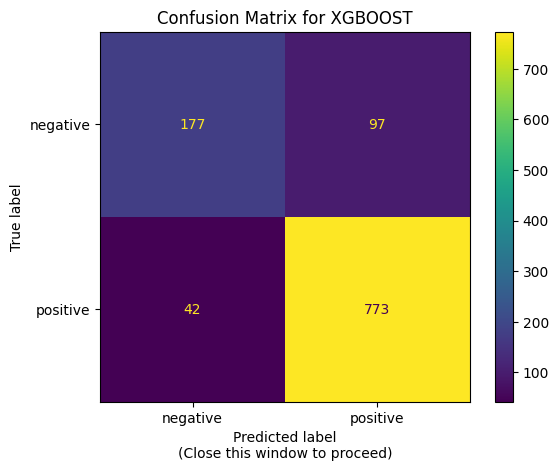

In [17]:
best_model_name, best_model_results = get_best_model(evaluation_output)

In [ ]:
metric_list = [] # accuracy, precision, recall
for metric, val in best_model_results['metrics'].items():
    if metric != 'cm':
        metric_list.append(val)
metric_list

## Update of Results

In [18]:
predicted_labels = best_model_results['prediction']
predicted_prob = best_model_results['prediction_prob']

In [ ]:
df['predcited_prob'] = predicted_prob
df['predicted_sentiment'] = predicted_labels
df.head()

In [ ]:
# save results
df_to_save = df.loc[:, ['Sentiment', 'Time', 'Text', 'predcited_prob', 'predicted_sentiment']]
display(df_to_save)
# df_to_save.to_csv("reviews_results.csv")

# Topic Classification

### Gensim

In [1]:
# from topic_modelling import *
# topic_modelling.py:
# a. tfidf
# b. topic classifcation
import topic_modelling.lda_sklearn as lda_sklearn

### SK Learn

#### Get ideal no. of topics

In [18]:
df = pd.read_csv('data/curated/reviews/cleaned_reviews.csv')
vectorized_text = lda_sklearn.vectorize(df)
n_topic = lda_sklearn.get_n_topic(df,vectorized_text)
n_topic

3

#### Top 10 words in each topic

Topic 0: 
coffee price buy cup product dog great taste love like
Topic 1: 
order product great good free price chip taste love tasty
Topic 2: 
tea taste flavor like drink water use good great try


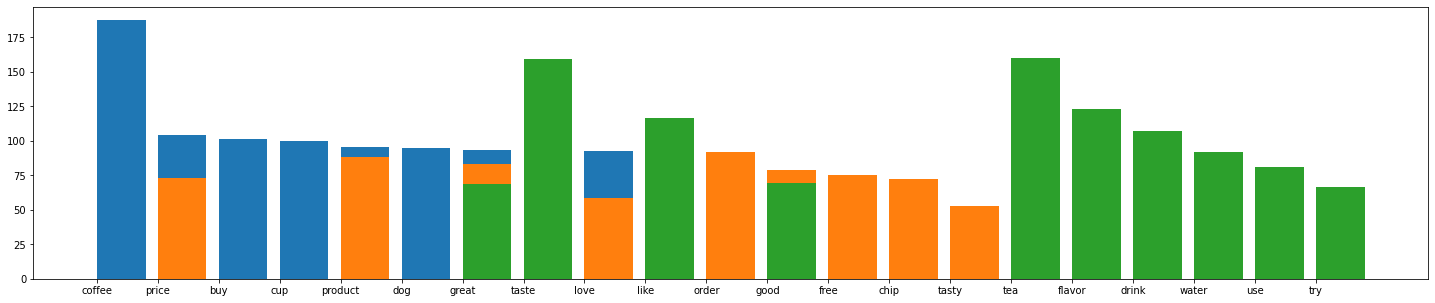

In [5]:
lda_model_sklearn = lda_sklearn.build_lda(n_topic,vectorized_text)
lda_sklearn.get_topics(lda_model_sklearn,df)

#### Topic breakdown

In [6]:
lda_sklearn.get_dominant_topics(lda_model_sklearn,df) #Fairly even

0    2209
1    1621
2    1614
Name: dominant_topic, dtype: int64

#### Breakdown of the probability of each doc belonging to each topic

,Topic0,Topic1,Topic2,dominant_topic
Doc0,0.77,0.12,0.11,0
Doc1,0.79,0.12,0.09,0
Doc2,0.66,0.08,0.26,0
Doc3,0.20,0.14,0.67,2
Doc4,0.85,0.08,0.08,0
...,...,...,...,...
Doc5439,0.39,0.41,0.19,1
Doc5440,0.37,0.57,0.07,1
Doc5441,0.17,0.12,0.71,2
Doc5442,0.69,0.21,0.10,0


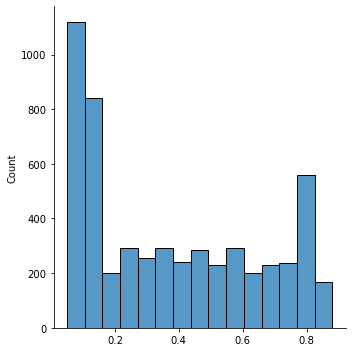

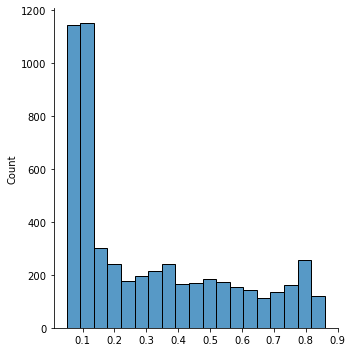

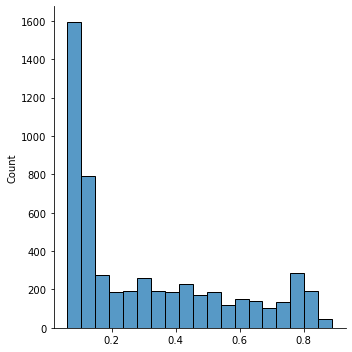

In [7]:
lda_sklearn.get_topic_weights(lda_model_sklearn,df)